In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

train_data = pd.read_csv('data/train.csv')
print(train_data.shape)
oil_df = pd.read_csv('data/oil.csv')
oil_df.columns = ['date', 'oil_price']

(3000888, 6)


# Oil EDA and transformation

In [43]:
oil_df = pd.read_csv('data/oil.csv')
oil_df.columns = ['date', 'oil_price']
oil_df['date'] = pd.to_datetime(oil_df['date'])

def fill_nan_with_mean_from_prev_and_next(col):
    df_filled_forward = col.ffill()

    # Backward fill NaN values
    df_filled_backward = col.bfill()

    # Fill NaN values with the average of previous and next value
    return (df_filled_forward + df_filled_backward) / 2

In [44]:
print(F"Shape: {oil_df.shape}")
print(oil_df['oil_price'].isnull().sum())

Shape: (1218, 2)
43


In [45]:
print(oil_df['date'].min())
print(oil_df['date'].max())

2013-01-01 00:00:00
2017-08-31 00:00:00


There are missing dates in the data. I will fill them with the last known value. I will also create a new feature that is the difference between the current day and the previous day. This will help the model to understand the trend in the data.

In [46]:
complete_dates = pd.date_range(start="2013-01-01", end="2017-08-31")
complete_df = pd.DataFrame({"date": complete_dates})
merged_days_oil_df = pd.merge(complete_df, oil_df, on="date", how="left")
merged_days_oil_df["oil_price"] = fill_nan_with_mean_from_prev_and_next(
    merged_days_oil_df["oil_price"]
)
merged_days_oil_df = merged_days_oil_df.ffill().bfill()
print(F"Shape: {merged_days_oil_df.shape}")
print(merged_days_oil_df['oil_price'].isnull().sum())

Shape: (1704, 2)
0


In [6]:
merged_days_oil_df.head(5)

,date,oil_price
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.16


<Axes: >

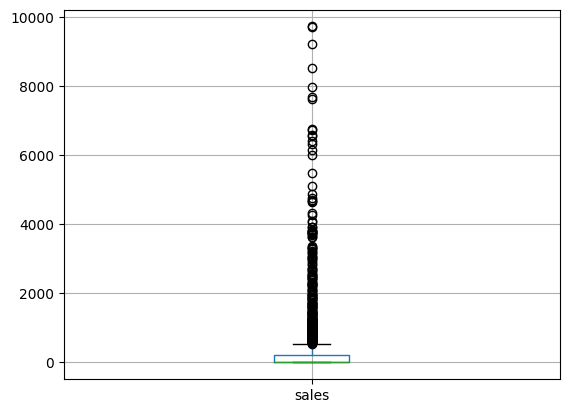

In [7]:
train_data.groupby(['family', 'store_nbr'])[['sales']].mean().boxplot()

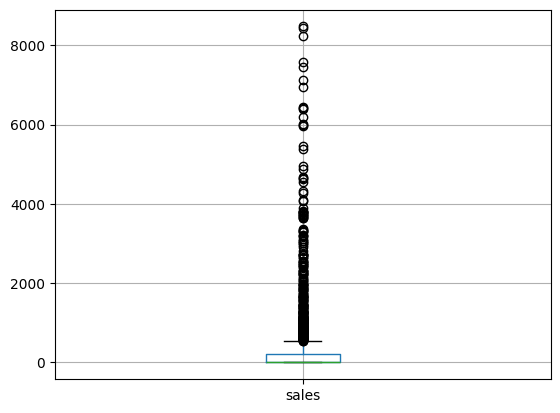

In [8]:
def cap_sales(df):
    df.sales = df.sales.map(lambda x: x if x < 10000 else 10000)
    return df
train_data = cap_sales(train_data)
train_data.groupby(['family', 'store_nbr'])[['sales']].mean().boxplot()
plt.show()

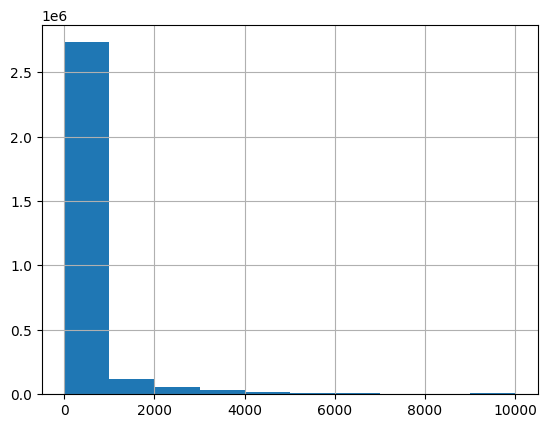

In [9]:
import matplotlib.pyplot as plt
train_data.sales.hist()
plt.show()

# Stores EDA and transformation

In [10]:
stores_df = pd.read_csv('data/stores.csv')
merged_store_train = pd.merge(train_data, stores_df, on=['store_nbr','store_nbr'])
# merged_store_train = merged_store_train.drop(['store_nbr'], axis=1)

# Holidays EDA

In [11]:
holidays_df = pd.read_csv('data/holidays_events.csv')

holidays_filtered = holidays_df[~holidays_df['transferred']].copy()
holidays_filtered['is_holiday'] = True
holidays_filtered = holidays_filtered.drop(['type', 'description', 'transferred'], axis=1)
local_holidays = holidays_filtered[holidays_filtered.locale == 'Local'].copy()
regional_holidays = holidays_filtered[holidays_filtered.locale == 'Regional'].copy()
national_holidays = holidays_filtered[holidays_filtered.locale == 'National'].copy()

holidays_filtered.head()

,date,locale,locale_name,is_holiday
0,2012-03-02,Local,Manta,True
1,2012-04-01,Regional,Cotopaxi,True
2,2012-04-12,Local,Cuenca,True
3,2012-04-14,Local,Libertad,True
4,2012-04-21,Local,Riobamba,True


In [12]:
national_indexes = pd.merge(merged_store_train, national_holidays, on='date', how='left')['is_holiday']
regional_indexes = pd.merge(merged_store_train, regional_holidays, left_on=['date', 'state'], right_on=['date', 'locale_name'], how='left')['is_holiday']
local_indexes = pd.merge(merged_store_train, local_holidays, left_on=['date', 'city'], right_on=['date', 'locale_name'], how='left')['is_holiday']

In [13]:
final_indexes = national_indexes | regional_indexes | local_indexes

In [14]:
merged_store_train['is_holiday'] = final_indexes

In [15]:
merged_store_train['is_holiday'].value_counts()

is_holiday
False    2740980
True      259908
Name: count, dtype: int64

In [16]:
merged_store_train[['date','city','state', 'is_holiday']].loc[merged_store_train['date'] == '2017-07-25'].head(10)

,date,city,state,is_holiday
54846,2017-07-25,Quito,Pichincha,False
54847,2017-07-25,Quito,Pichincha,False
54848,2017-07-25,Quito,Pichincha,False
54849,2017-07-25,Quito,Pichincha,False
54850,2017-07-25,Quito,Pichincha,False
54851,2017-07-25,Quito,Pichincha,False
54852,2017-07-25,Quito,Pichincha,False
54853,2017-07-25,Quito,Pichincha,False
54854,2017-07-25,Quito,Pichincha,False
54855,2017-07-25,Quito,Pichincha,False


# Date Encoding

In [17]:
merged_store_train['day_of_week'] = pd.to_datetime(merged_store_train['date']).dt.dayofweek

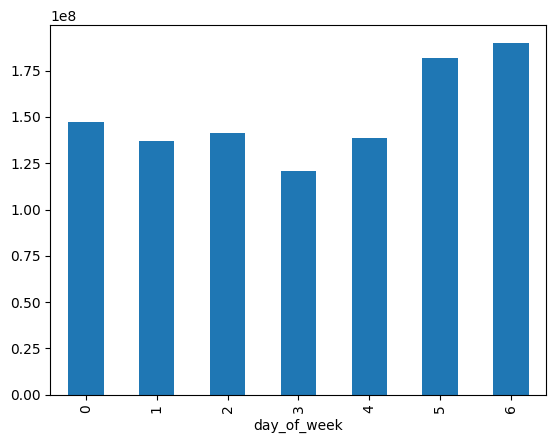

In [18]:
merged_store_train.groupby('day_of_week')['sales'].sum().plot(kind='bar')
plt.show()

Conclusion: Clearly weekend days have higher sales than week days

In [19]:
merged_store_train['date'] = pd.to_datetime(merged_store_train['date'])

In [20]:
merged_store_train['is_weekend'] = merged_store_train['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

In [21]:
merged_store_train['month'] = pd.to_datetime(merged_store_train['date']).dt.month

In [22]:
merged_store_train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
city           0
state          0
type           0
cluster        0
is_holiday     0
day_of_week    0
is_weekend     0
month          0
dtype: int64

# Time Series Specific feature engineering

Lagging

In [34]:
def add_lagged_features(group, lags):
    for lag in lags:
        group[f'lagged_sales_{lag}'] = group['sales'].shift(lag)
    return group.reset_index(drop=True)

# Create a lagged variable for sales
grouped_data = merged_store_train.groupby(['store_nbr', 'family']).apply(add_lagged_features, lags=[1, 2])
grouped_data.reset_index(drop=True, inplace=True)
# Merge the lagged features back into the original DataFrame
sales_data = pd.merge(merged_store_train, grouped_data[['store_nbr', 'family', 'date', 'lagged_sales_1', 'lagged_sales_2']], on=['store_nbr', 'family', 'date'])

Rolling Window Statistics

In [38]:
def add_rolling_mean(group, window_sizes):
    for window_size in window_sizes:
        group[f'rolling_mean_{window_size}_days'] = group['sales'].rolling(window_size).mean()
    return group

# Create a rolling mean variables for sales
grouped_data = sales_data.groupby(['store_nbr', 'family']).apply(add_rolling_mean, window_sizes = [14, 28]) 
grouped_data.reset_index(drop=True, inplace=True)
# Merge the lagged features back into the original DataFrame
sales_data = pd.merge(sales_data, grouped_data[['store_nbr', 'family', 'date', 'rolling_mean_14_days', 'rolling_mean_28_days']], on=['store_nbr', 'family', 'date'])

In [40]:
sales_data.isnull().sum()

id                          0
date                        0
store_nbr                   0
family                      0
sales                       0
onpromotion                 0
city                        0
state                       0
type                        0
cluster                     0
is_holiday                  0
day_of_week                 0
is_weekend                  0
month                       0
lagged_sales_1           1782
lagged_sales_2           3564
rolling_mean_14_days    23166
rolling_mean_28_days    48114
dtype: int64

In [42]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 18 columns):
 #   Column                Dtype         
---  ------                -----         
 0   id                    int64         
 1   date                  datetime64[ns]
 2   store_nbr             int64         
 3   family                object        
 4   sales                 float64       
 5   onpromotion           int64         
 6   city                  object        
 7   state                 object        
 8   type                  object        
 9   cluster               int64         
 10  is_holiday            bool          
 11  day_of_week           int32         
 12  is_weekend            int64         
 13  month                 int32         
 14  lagged_sales_1        float64       
 15  lagged_sales_2        float64       
 16  rolling_mean_14_days  float64       
 17  rolling_mean_28_days  float64       
dtypes: bool(1), datetime64[ns](1), float64(5),

Pending: new attribute or approach for Ecuador's earthquake

Ready for data pipeline, where scalers and encoders will be applied